The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

In [1]:
suppressMessages(suppressWarnings({
    library(biomaRt)
    library(rtracklayer)
    library(BSgenome.Hsapiens.UCSC.hg19)
}))

In [2]:
suppressMessages(suppressWarnings({
    library(tidyverse)
    library(stringr)
    library(magrittr)
}))

# Fetch coordinates of different genomic regions

In [3]:
regions <- list()

## Protein coding and UTR coordinates

Show all the available biomarts for hg19:

In [4]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [5]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [6]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

### Protein coding coordinates

In [7]:
regions[["protein_coding"]] <-
    getBM(c("chromosome_name", "genomic_coding_start", "genomic_coding_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    select(chrom=chromosome_name, start=genomic_coding_start, end=genomic_coding_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [8]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### UTRs


More on the UTR vs protein_coding sizes in humans:
* http://seqanswers.com/forums/showthread.php?p=34995#post34995
* http://www.nature.com/nature/journal/v461/n7261/full/nature08250.html


Also: https://groups.google.com/forum/#!topic/biomart-users/OtQbAx3y9CA

#### 5' UTR

In [9]:
regions[["utr5"]] <-
    getBM(c("chromosome_name", "5_utr_start", "5_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [10]:
sum(width(regions[["utr5"]]))

[1] 10336680

#### 3' UTR

In [11]:
regions[["utr3"]] <-
    getBM(c("chromosome_name", "3_utr_start", "3_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [12]:
sum(width(regions[["utr3"]]))

[1] 37469434

## Get the coordinates of 5kb upstream of transcription start site

Make sure to correctly handle 5k upstream (on the fwd strand) ond 5k downstream (ond the rev strand) from the TSS.

In [13]:
listFilters(genes) %>% filter(str_detect(name, "biotype"))

name,description
biotype,Type
transcript_biotype,Transcript Type


In [14]:
tss <-
    getBM(c("chromosome_name", "transcription_start_site", "strand"),
          filters=c("chromosome_name", "transcript_biotype"),
          values=list(1:22, "protein_coding"),
          mart=genes) %>%
    setNames(c("chrom", "pos", "strand")) %>% 
    mutate(strand=ifelse(strand == 1, "-", "+")) %>% 
    arrange(chrom, pos) %>%
    makeGRangesFromDataFrame(start.field="pos", end.field="pos")

In [15]:
length(tss)
length(IRanges::reduce(tss))

[1] 70555

[1] 69368

In [16]:
regions[["tss_5k"]] <- resize(tss, width=5001)
strand(regions[["tss_5k"]]) <- "*"
regions[["tss_5k"]] %<>% IRanges::reduce()

In [17]:
sum(width(regions[["tss_5k"]]))

[1] 157469652

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [18]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [19]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh37.p13),GRCh37.p13
hsapiens_motif_feature,Human Binding Motifs (GRCh37.p13),GRCh37.p13
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh37.p13),GRCh37.p13
hsapiens_regulatory_feature,Human Regulatory Features (GRCh37.p13),GRCh37.p13
hsapiens_external_feature,Human Other Regulatory Regions (GRCh37.p13),GRCh37.p13


In [20]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [21]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%
    mutate(feature=str_replace_all(tolower(feature), " ", "_"),
           feature=str_replace(feature, "flanking_region", "flank"))

In [22]:
table(regulatory_features_df$feature)


ctcf_binding_site          enhancer    open_chromatin          promoter 
            55194             27577            107233             14287 
   promoter_flank   tf_binding_site 
            45496             22376 

In [23]:
regions <- c(regions, lapply(split(regulatory_features_df, regulatory_features_df$feature),
                             function(df) {
                                 IRanges::reduce(makeGRangesFromDataFrame(df))
                             }))

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [24]:
library(rtracklayer)

In [25]:
session <- browserSession()
genome(session) <- "hg19"

In [26]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [27]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [28]:
tableName(query) <- "phastConsElements46wayPrimates"

In [29]:
regions[["priPhastCons"]] <-
    getTable(query) %>%
    select(-bin, -name, -score) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)

Keep only those priPhastCons-infered regions that do not overlap anything else:

## Reduce all regions and convert their coordinates to UCSC hg19

Convert all coordinate dataframes into individual `GRanges` objects:

In [30]:
regions <- lapply(regions,
                  function(r) {
                      reduced_r <- IRanges::reduce(r)
                      seqlevelsStyle(reduced_r) <- "UCSC"
                      seqinfo(reduced_r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
                      
                      reduced_r
                  })

## Get a set of phastCons conserved regions that do not overlap anything else

In [31]:
uniq_reg <- regions[["priPhastCons"]]

for (reg in setdiff(names(regions), "priPhastCons")) {
        uniq_reg <- IRanges::setdiff(uniq_reg, regions[[reg]])
}

regions[["priPhastCons_uniq"]] <- uniq_reg

## Get coordinates of all putatively non-functional regions

First get the reduce set of annotated regions (everything mashed together):

In [32]:
(all_regions <- unlist(GRangesList(regions)) %>% IRanges::reduce() %>% sort)

GRanges object with 751323 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1       [ 9880, 10734]      *
       [2]     chr1       [11001, 11800]      *
       [3]     chr1       [13371, 13724]      *
       [4]     chr1       [13908, 14498]      *
       [5]     chr1       [15462, 15778]      *
       ...      ...                  ...    ...
  [751319]    chr22 [51221197, 51227091]      *
  [751320]    chr22 [51231014, 51231196]      *
  [751321]    chr22 [51235000, 51235201]      *
  [751322]    chr22 [51237212, 51237544]      *
  [751323]    chr22 [51239150, 51239664]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

Get lengths of all hg19 chromosomes:

In [33]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
hg19 <- hg19[seqnames(hg19) %in% paste0("chr", 1:22)]

Everything in hg19 that is not in the annotated set of functional regions is a gap or "junk":

In [34]:
(regions[["gap"]] <- IRanges::setdiff(hg19, all_regions))

GRanges object with 751344 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1       [    1,  9879]      *
       [2]     chr1       [10735, 11000]      *
       [3]     chr1       [11801, 13370]      *
       [4]     chr1       [13725, 13907]      *
       [5]     chr1       [14499, 15461]      *
       ...      ...                  ...    ...
  [751340]    chr22 [51227092, 51231013]      *
  [751341]    chr22 [51231197, 51234999]      *
  [751342]    chr22 [51235202, 51237211]      *
  [751343]    chr22 [51237545, 51239149]      *
  [751344]    chr22 [51239665, 51304566]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

### Total amount of sequence in each genomic region

In [35]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(as.numeric(width(IRanges::reduce(r))))} ) / 1e6
) %>% arrange(length)

region,length
utr5,10.33668
tf_binding_site,10.48753
enhancer,18.27491
promoter,22.68667
protein_coding,33.84488
utr3,37.46943
ctcf_binding_site,41.23060
open_chromatin,51.20425
priPhastCons_uniq,56.98052
promoter_flank,59.75196


<br><br><br><br><br><br><br><br><br><br>

## Get coordinates of admixture array sites

* Add intergenic regions too - actually, regions are not necessary, just takes SNPs that don't overlap anything.
* Check how many admixture array sites fall within each functional region.

In [33]:
source("../R/utils.R")

In [34]:
suppressMessages({

# load the sample information
sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    dplyr::select(-Country, -Latitude, -Longitude, pop=Region) %>%
    mutate(age=0) %>%
    group_by(name, age, pop) %>%
    ungroup
emhs <- read_delim("../clean_data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"), pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

# load genotypes at archaic admixture sites
genotypes <-
    load_dataset("../clean_data/ice_age.tsv",
                 "../clean_data/sgdp.tsv",
                 "../clean_data/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", sgdp$name)) %>%
    mutate(start=pos, end=pos) %>%
    select(-pos) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [35]:
seqlevelsStyle(genotypes) <- "UCSC"
seqinfo(genotypes) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

In [36]:
sites <- granges(genotypes)

## Calculate Neanderthal allele frequency at each locus

In [37]:
freq_eur <- 1/2 * apply(mcols(genotypes)[filter(samples, pop == "WestEurasia")$name], 1, mean, na.rm=TRUE)
freq_all <- 1/2 * apply(mcols(genotypes)[filter(samples, pop != "EMH")$name], 1, mean, na.rm=TRUE)

In [38]:
mcols(sites)[["freq_eur"]] <- freq_eur
mcols(sites)[["freq_all"]] <- freq_all

In [39]:
summary(sites$freq_eur)
summary(sites$freq_all)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.01830 0.01493 1.00000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.002538 0.020440 0.020300 1.000000 

## Get the hits of each site in different genomic regions

In [40]:
for (r in names(regions)) {
    col_name <- paste0("hits_", r)

    # find which sites are falling within a given region
    hits <- findOverlaps(sites, regions[[r]])

    # mark which sites hit a region
    mcols(sites)[[col_name]] <- 0
    mcols(sites[queryHits(hits)])[[col_name]] <- 1
}

## Get average primate phastCons per window

## Add B value to each locus

In [41]:
source("../R/assign_bvals.R")


Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’

The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens



In [42]:
sites <- assign_bvals(sites, bval_path="../raw_data/bkgd/", chain_path="../raw_data/hg18ToHg19.over.chain")

## Number of admixture array sites in each genomic region

In [43]:
sapply(regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site              utr5          enhancer               cds 
             2257              2391              4020              4953 
         promoter              utr3 ctcf_binding_site    open_chromatin 
             5189              6821              8518             11158 
priPhastCons_uniq    promoter_flank      priPhastCons            tss_5k 
            11169             13208             17443             27598

## Convert the final `GRanges` object to a normal data frame for the analyses bellow

In [44]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames) %>%
    filter(complete.cases(.))

In [45]:
head(tbl)

chrom,start,end,freq_eur,freq_all,hits_cds,hits_utr5,hits_utr3,hits_tss_5k,hits_ctcf_binding_site,hits_enhancer,hits_open_chromatin,hits_promoter,hits_promoter_flank,hits_tf_binding_site,hits_priPhastCons,hits_priPhastCons_uniq,bval
chr1,847983,847983,0,0.005076142,0,0,0,0,1,0,0,0,0,0,0,0,958
chr1,853089,853089,0,0.005102041,0,0,0,0,1,0,0,0,0,0,0,0,958
chr1,853596,853596,0,0.005076142,0,0,0,0,0,0,0,0,0,0,0,0,958
chr1,854793,854793,0,0.005076142,0,0,0,0,0,0,0,0,0,0,0,0,958
chr1,867552,867552,0,0.005076142,0,0,0,1,1,0,0,0,0,0,1,0,946
chr1,871401,871401,0,0.007614213,0,0,0,1,0,0,1,0,0,0,0,0,946


<br><br><br><br><br>

## Modeling the dependence of Nea. frequency on functional predictors

In [46]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_cds + hits_utr5 + hits_utr3 + 
    hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.238  -1.192   1.153   1.163   1.328  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.034008   0.003089  11.009 < 0.0000000000000002 ***
hits_cds               -0.048072   0.028902  -1.663             0.096258 .  
hits_utr5              -0.055135   0.043663  -1.263             0.206682    
hits_utr3              -0.090377   0.024617  -3.671             0.000241 ***
hits_tss_5k            -0.088652   0.012867  -6.890     0.00000000000558 ***
hits_promoter          -0.146750   0.030273  -4.848     0.00000124989234 ***
hits_promoter_flank    -0.062049   0.017737  -3.498             0.000468 ***
hits_ctcf

In [47]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_priPhastCons + hits_cds + hits_utr5 + 
    hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + 
    hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + 
    hits_tf_binding_site, family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.242  -1.193   1.152   1.162   1.334  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.037271   0.003121  11.944 < 0.0000000000000002 ***
hits_priPhastCons      -0.118220   0.015989  -7.394    0.000000000000143 ***
hits_cds                0.003926   0.029755   0.132             0.895023    
hits_utr5              -0.048400   0.043680  -1.108             0.267836    
hits_utr3              -0.081013   0.024654  -3.286             0.001016 ** 
hits_tss_5k            -0.088991   0.012868  -6.916    0.000000000004655 ***
hits_promoter          -0.142084   0.030283  -4.692    0.000002707

In [48]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ bval + hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ bval + hits_cds + hits_utr5 + hits_utr3 + 
    hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.391  -1.212   1.075   1.126   1.583  

Coefficients:
                          Estimate  Std. Error z value             Pr(>|z|)    
(Intercept)            -0.87718612  0.01252854 -70.015 < 0.0000000000000002 ***
bval                    0.00112485  0.00001494  75.268 < 0.0000000000000002 ***
hits_cds                0.11961618  0.02926832   4.087            0.0000437 ***
hits_utr5              -0.00058235  0.04407455  -0.013             0.989458    
hits_utr3               0.08647828  0.02494120   3.467             0.000526 ***
hits_tss_5k             0.05463968  0.01312161   4.164            0.0000313 ***
hits_promoter          -0.03823643  0.03058664  -1.250    

In [49]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ bval + hits_priPhastCons + hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ bval + hits_priPhastCons + hits_cds + 
    hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + 
    hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + 
    hits_tf_binding_site, family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.396  -1.212   1.074   1.127   1.612  

Coefficients:
                          Estimate  Std. Error z value             Pr(>|z|)    
(Intercept)            -0.87310948  0.01255079 -69.566 < 0.0000000000000002 ***
bval                    0.00112276  0.00001495  75.104 < 0.0000000000000002 ***
hits_priPhastCons      -0.08617378  0.01609620  -5.354         0.0000000862 ***
hits_cds                0.15710952  0.03011499   5.217         0.0000001819 ***
hits_utr5               0.00424986  0.04409069   0.096             0.923212    
hits_utr3               0.09294609  0.02497865   3.721             0.000198 ***
hits_tss_5k             0.05412109  0.

<br><br><br><br><br>

## Neanderthal ancestry proportions at sites in different functional regions

Join the tables of SGDP genotypes and hits of SNPs in different regions:

In [50]:
sample_ids <- filter(samples, pop != "EMH")$name

In [51]:
gt_hits <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    gather(region, hits, -c(1:3), -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
    select(-seqnames, -start, -end) %>%
    gather(name, gt, -region, -hits)

Joining, by = c("seqnames", "start", "end")


In [52]:
head(gt_hits)

region,hits,name,gt
hits_cds,0,S_Chane_1,0
hits_cds,0,S_Chane_1,0
hits_cds,0,S_Chane_1,0
hits_cds,0,S_Chane_1,0
hits_cds,0,S_Chane_1,0
hits_cds,0,S_Chane_1,0


Calculate Nea. ancestry in each individual in different regions of the genome:

In [53]:
hits_nea <-
    group_by(gt_hits, name, region, hits) %>%
    summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
    ungroup %>% 
    mutate(hits=factor(hits),
           region=str_replace(region, "hits_", ""))

In [54]:
genome_wide <- as.data.frame(mcols(genotypes)) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    gather(name, nea) %>%
    mutate(region="genome_wide", hits="-")

### all SGDP non-African samples except Oceanians

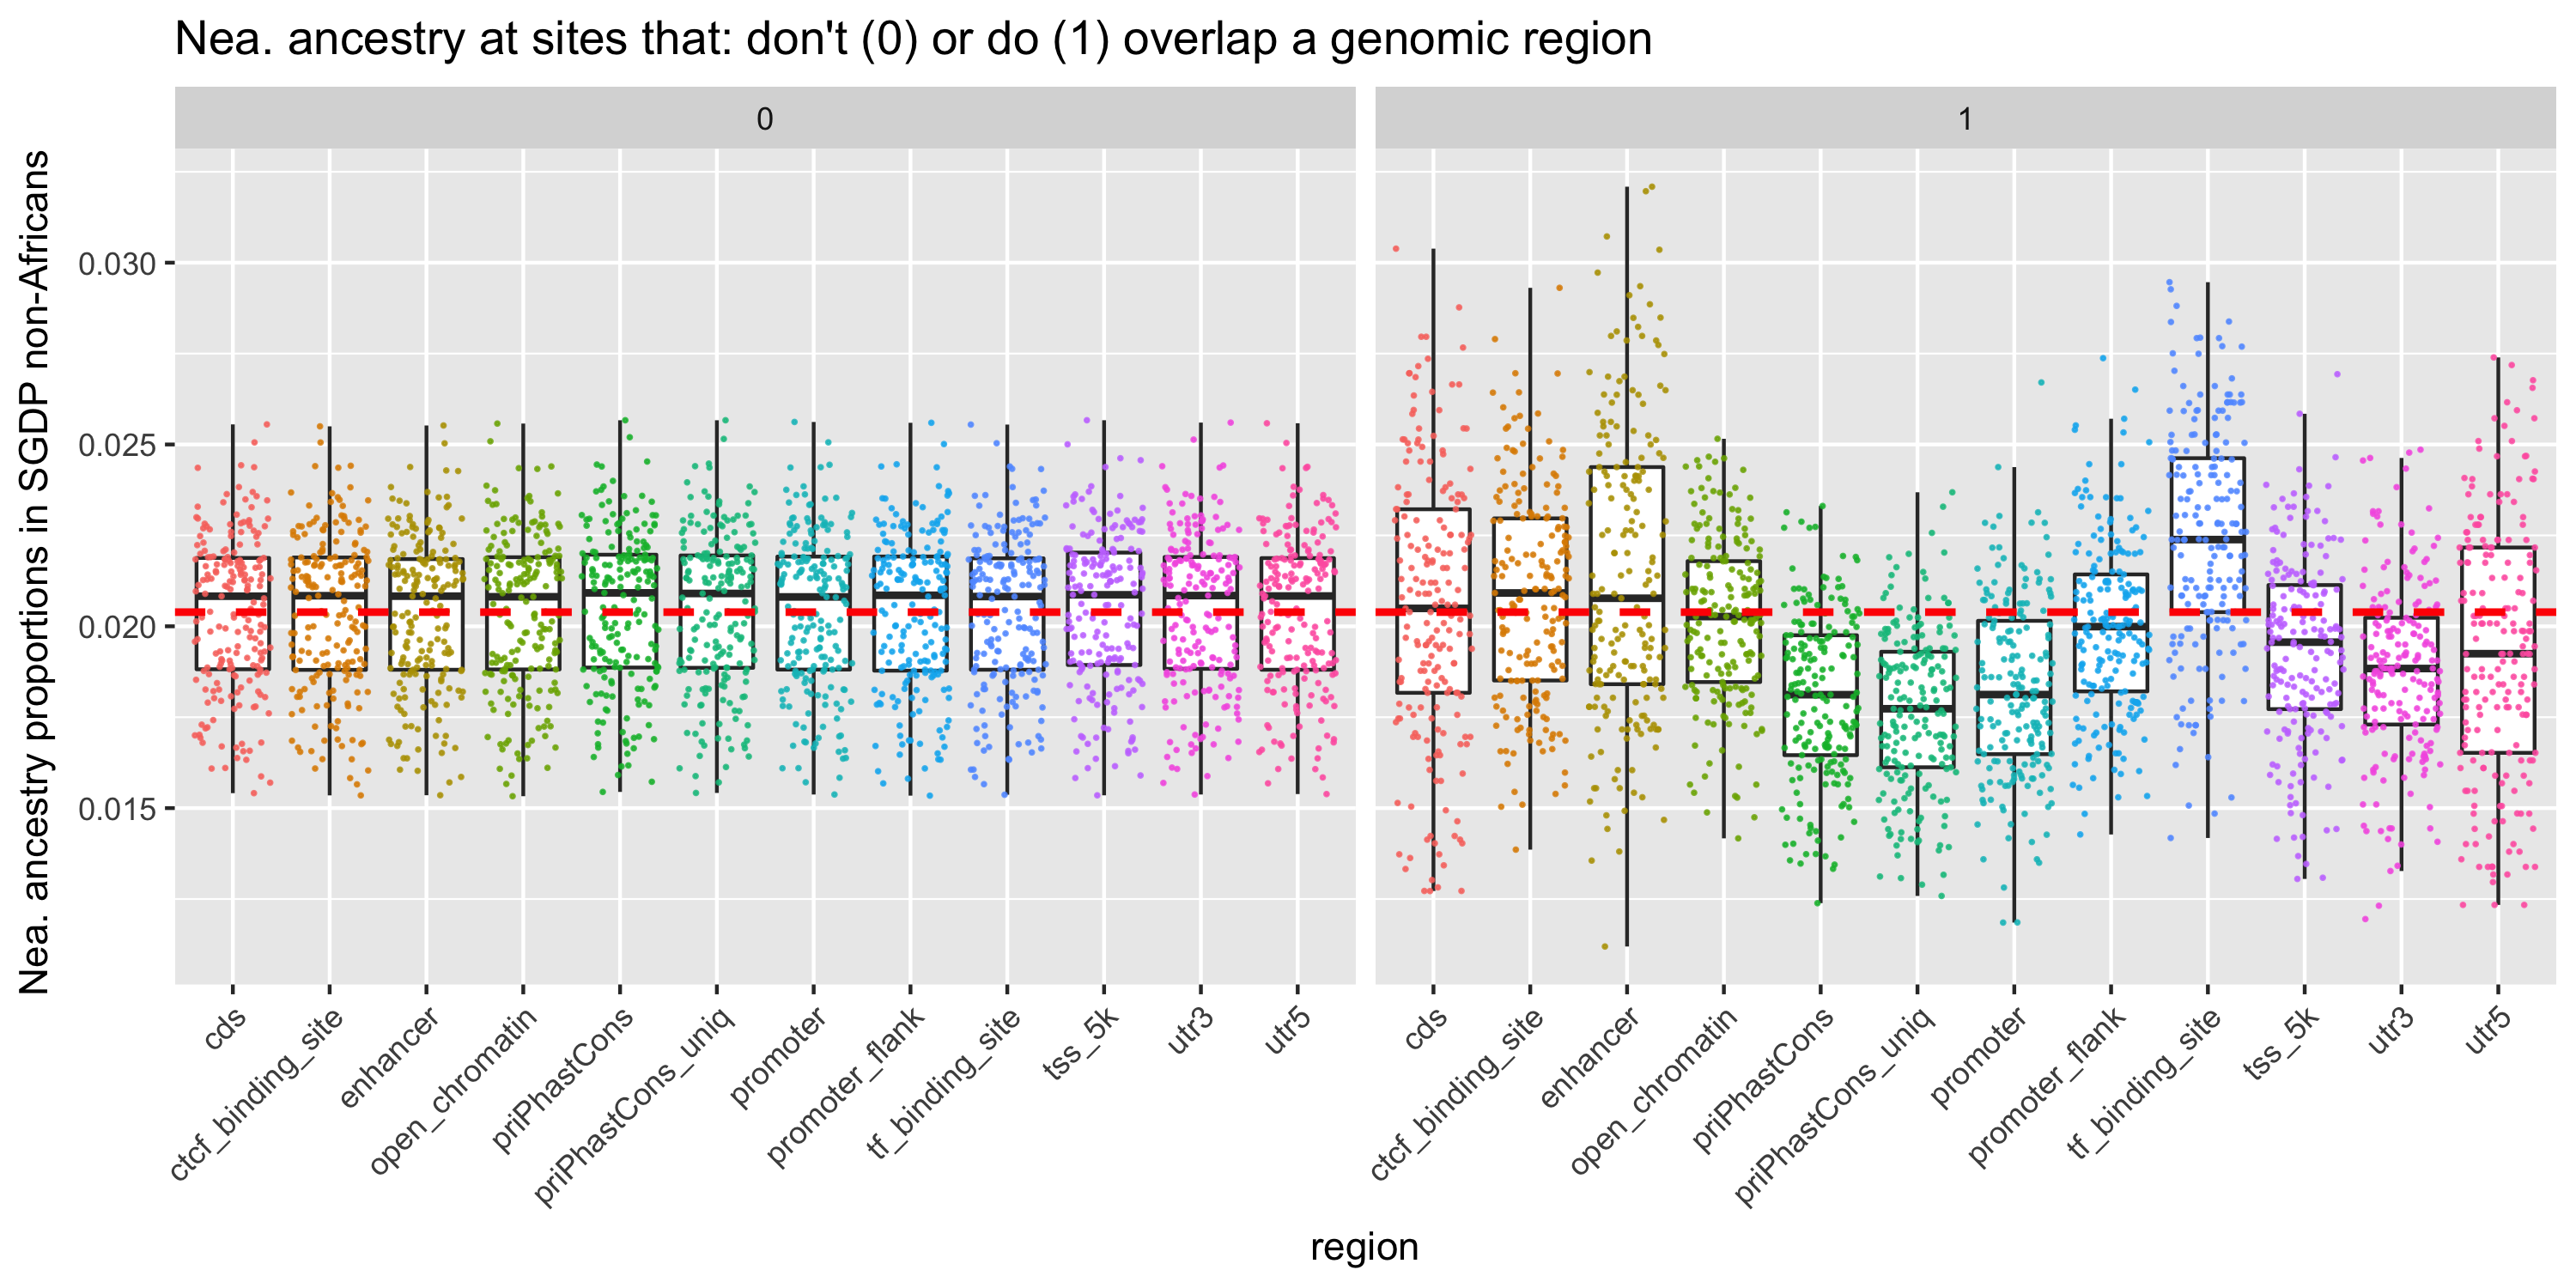

In [55]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(bind_rows(hits_nea) %>% filter(complete.cases(.)), aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=mean(genome_wide$nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

### Formally testing the distributions

Statistical test to find out whether selection performed differently among different functional categories:

http://rpubs.com/ibecav/308410

### ANOVA

### Non-parametric testing - Kruskal-Wallis rank sum test

In [127]:
library(dunn.test)

filter(hits_nea, hits == 1) %>% 
{ dunn.test(.[["nea"]], .[["region"]], method = "holm", alpha = 0.01) }

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 408.0031, df = 11, p-value = 0


                           Comparison of x by group                            
                                    (Holm)                                     
Col Mean-|
Row Mean |        cds   ctcf_bin   enhancer   open_chr   priPhast   priPhast
---------+------------------------------------------------------------------
ctcf_bin |  -1.232667
         |     0.6531
         |
enhancer |  -1.425859  -0.193192
         |     0.6926     0.8468
         |
open_chr |   0.284566   1.517233   1.710426
         |     1.0000     0.6460     0.4795
         |
priPhast |   7.649422   8.882089   9.075281   7.364855
         |    0.0000*    0.0000*    0.0000*    0.0000*
         |
priPhast |   8.953682   10.18635   10.37954   8.669116   1.304260
         |    0.0000*    0.0000*    0.0000*    0.0000*     0.7686
         |
promoter |   7.025301   8.257968   8.451161   6.740735  -0.624120  -

In [56]:
save.image("../RData/introgression_predictors.RData")

<br><br><br><br><br>

## Size of overlaps between each pair of _functional_ genomic regions

I define "functional" functional regions as those that show a significant depletion or enrichment for Nea. ancestry in the logistic regression analysis.

In [25]:
functional_regions <- c("protein_coding", "promoter", "priPhastCons", "utr3", "tf_binding_site")

In [26]:
overlaps <- matrix(rep(NA, length(functional_regions) ^ 2), nrow=length(functional_regions))
colnames(overlaps) <- rownames(overlaps) <- functional_regions

In [27]:
for (r1 in functional_regions) {
    for (r2 in setdiff(functional_regions, r1)) {
        r1_gr <- regions[[r1]]
        r2_gr <- regions[[r2]]

        overlaps[r1, r2] <- sum(width(IRanges::intersect(r1_gr, r2_gr))) / sum(width(r1_gr)) 
    }
}

In [28]:
overlaps

,cds,utr5,utr3,tss_5k,ctcf_binding_site,enhancer,open_chromatin,promoter,promoter_flank,tf_binding_site,priPhastCons,priPhastCons_uniq
cds,NA,0.049916021,0.17361906,0.15142917,0.02761974,2.893524e-03,0.0242140282,0.051009628,4.172217e-02,0.0113411820,0.61536838,0.0000000
utr5,0.163437583,NA,0.03876457,0.50055027,0.02933340,4.863457e-03,0.0185697922,0.401536277,8.569841e-02,0.0146414516,0.24409811,0.0000000
utr3,0.156824280,0.010693970,NA,0.10055220,0.02465764,6.548724e-03,0.0254803155,0.009075050,3.306343e-02,0.0087620752,0.25579652,0.0000000
tss_5k,0.032546608,0.032857303,0.02392610,NA,0.03550089,8.215018e-03,0.0190093200,0.080413857,4.842327e-02,0.0083184854,0.05863172,0.0000000
ctcf_binding_site,0.022672166,0.007354004,0.02240831,0.13558651,NA,1.488923e-02,0.0712938466,0.005935422,9.195244e-02,0.0498221721,0.05382236,0.0000000
enhancer,0.005358768,0.002750876,0.01342699,0.07078646,0.03359207,NA,0.0000000000,0.000000000,7.655305e-05,0.0000000000,0.08015083,0.0000000
open_chromatin,0.016004941,0.003748712,0.01864558,0.05845982,0.05740711,0.000000e+00,NA,0.000000000,3.903973e-04,0.0000000000,0.09872298,0.0000000
promoter,0.076098228,0.182951174,0.01498841,0.55815793,0.01078700,0.000000e+00,0.0000000000,NA,0.000000e+00,0.0000000000,0.15302011,0.0000000
promoter_flank,0.023632395,0.014825237,0.02073351,0.12761413,0.06344987,2.341346e-05,0.0003345497,0.000000000,NA,0.0003891253,0.08112098,0.0000000
tf_binding_site,0.036599735,0.014430846,0.03130478,0.12490151,0.19587043,0.000000e+00,0.0000000000,0.000000000,2.217013e-03,NA,0.08811890,0.0000000


In [18]:
overlaps

,cds,promoter,priPhastCons,utr3,tf_binding_site
cds,NA,0.05100963,0.6153684,0.17361906,0.011341182
promoter,0.07609823,NA,0.1530201,0.01498841,0.000000000
priPhastCons,0.20615760,0.03436294,NA,0.09487306,0.009147735
utr3,0.15682428,0.00907505,0.2557965,NA,0.008762075
tf_binding_site,0.03659973,0.00000000,0.0881189,0.03130478,NA


## Subset of unique regions that show significant Nea. ancestry differences

In [60]:
subset_regions <- regions[c("protein_coding", "promoter", "utr3", "tf_binding_site")]

In [59]:
for (r1 in names(subset_regions)) {
    for (r2 in setdiff(names(subset_regions), r1)) {
        subset_regions[[r1]] <- IRanges::setdiff(subset_regions[[r1]], subset_regions[[r2]])
    }
}

In [60]:
sapply(subset_regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site             cds        promoter            utr3  promoter_flank 
           2257            3649            5189            6404           13208

In [61]:
tibble(
    region=names(subset_regions),
    length=sapply(subset_regions, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
) %>% arrange(length)

region,length
tf_binding_site,10.48753
promoter,22.68667
cds,24.74383
utr3,35.56222
promoter_flank,59.72871


In [62]:
x <- regions

In [63]:
regions <- subset_regions

<br><br><br><br><br><br><br><br><br><br>
# Export coordinates of genomic regions in BED format

In [185]:
sum(width(IRanges::intersect(regions[["protein_coding"]], regions[["promoter"]])))/33844885

[1] 0.05100963

In [187]:
sum(width(IRanges::intersect(regions[["protein_coding"]], regions[["utr3"]])))/33844885

[1] 0.1736191

In [177]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### Get only nonoverlapping sequences

In [211]:
x <- regions[c("protein_coding", "promoter", "promoter_flank", "utr3", "tf_binding_site")]

In [212]:
for (r1 in names(x)) {
    for (r2 in setdiff(names(x), r1)) {
        x[[r1]] <- IRanges::setdiff(x[[r1]], x[[r2]])
    }
}

In [220]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region,length
cds,19.632317
utr5,2.755755
utr3,30.486345
tss_5k,127.374202
ctcf_binding_site,31.593284
enhancer,18.273509
open_chromatin,51.184259
promoter,22.686665
promoter_flank,59.728712
tf_binding_site,10.487535


In [213]:
tibble(
    region=names(x),
    length=sapply(x, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region,length
cds,19.632317
utr5,2.755755
utr3,30.486345
tss_5k,127.374202
ctcf_binding_site,31.593284
enhancer,18.273509
open_chromatin,51.184259
promoter,22.686665
promoter_flank,59.728712
tf_binding_site,10.487535


In [192]:
tibble(
    region=names(x),
    length=sapply(x, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region,length
cds,24.74383
promoter,22.34663
promoter_flank,58.48984
utr3,37.14112
tf_binding_site,10.48753


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Archive

### West Eurasians only

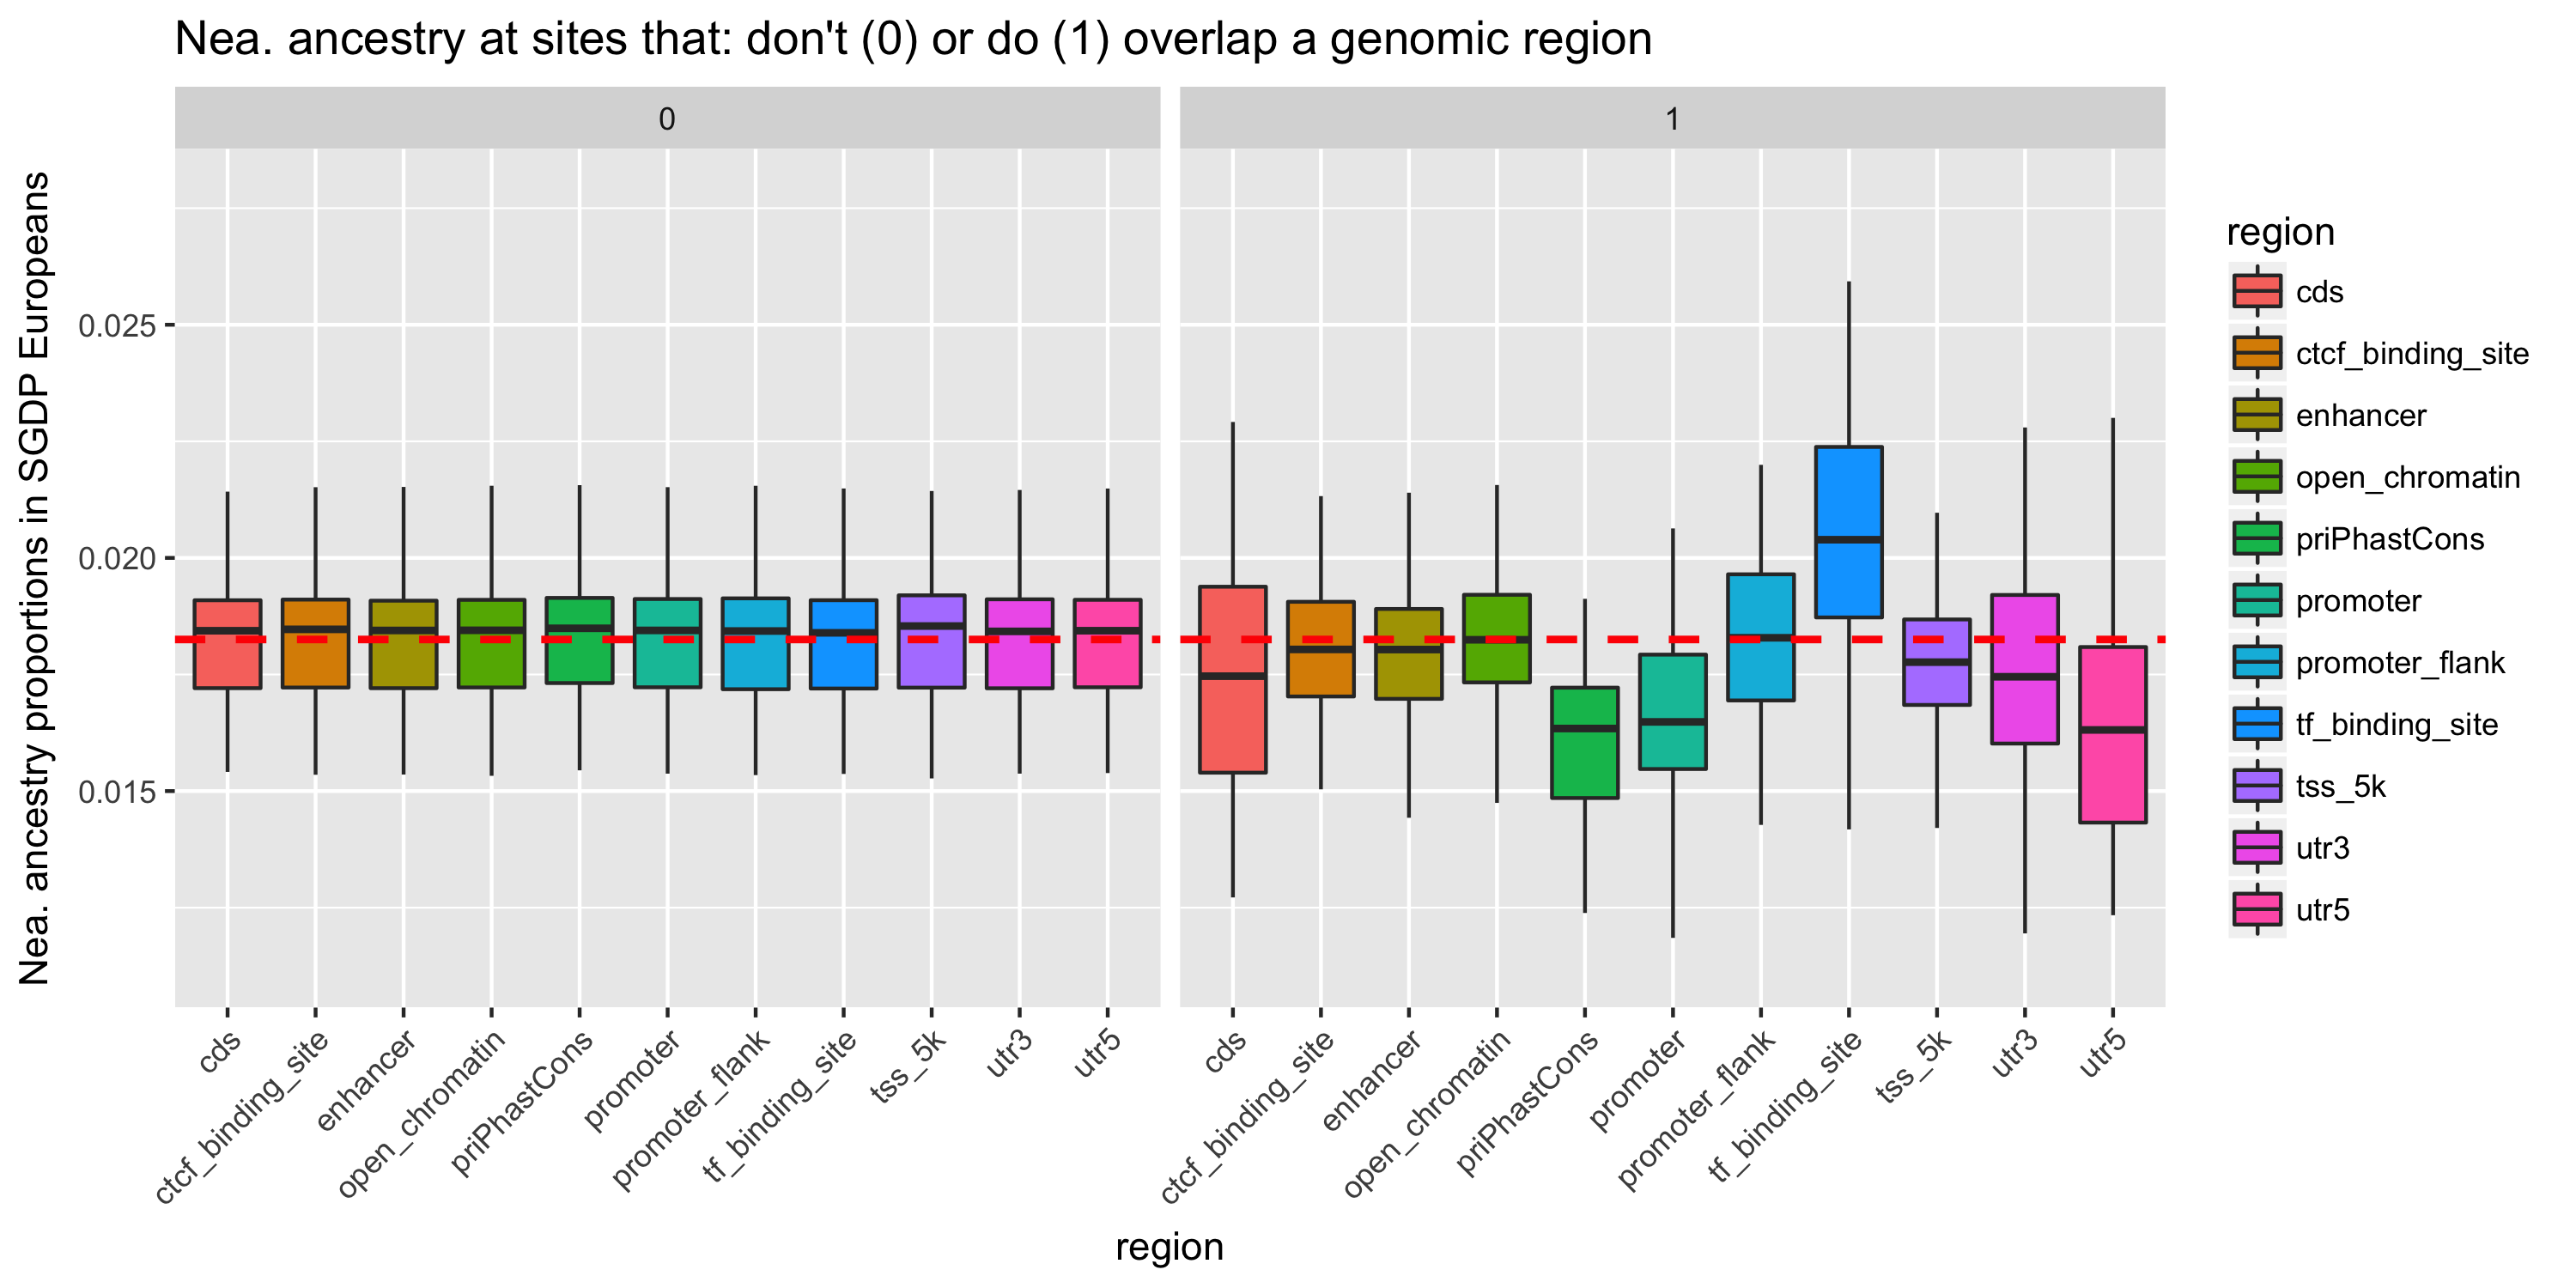

In [101]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(bind_rows(hits_nea) %>% filter(complete.cases(.)), aes(region, nea, fill=region)) +
    geom_boxplot(outlier.size=NA) +
    geom_hline(yintercept=mean(genome_wide$nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP Europeans", "genomic region")